<a href="https://colab.research.google.com/github/VitorSRamos/CNN-MorfGal/blob/main/exemplos%20de%20treinamento/EN_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação

## Módulos

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint

In [ ]:
os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.random.set_seed(12345)

## Dados

In [ ]:
def normalize_array(array):
    min = np.min(array)
    max = np.max(array)

    return (array - np.min(array)) / (np.max(array) - np.min(array))


def get_img_from_fits(path, filename, norm_type = None, show=False):
    # Função que gera imagem (array do numpy) a partir de um arquivo fits
    
    # abrindo a imagem
    my_file = fits.open(path+filename)
    
    # Aplicando normalização
    if norm_type == 'band': # Caso banda a banda
        norm_array1 = normalize_array(my_file[1].data)
        norm_array2 = normalize_array(my_file[2].data)
        norm_array3 = normalize_array(my_file[3].data)
        image_data = np.stack((norm_array1, norm_array2, norm_array3), axis=2)
    
    elif norm_type == 'full':
        raw_img = np.stack((my_file[1].data, my_file[2].data, my_file[3].data), axis=2)
        image_data = normalize_array(raw_img)
    
    elif norm_type == None:
        image_data = np.stack((my_file[1].data, my_file[2].data, my_file[3].data), axis=2)
    
    
    # Extraindo rótulos
    if my_file[0].header['SPIRAL'] == 1:
        label = 0
    elif my_file[0].header['ELLIPTICAL'] == 1:
        label = 1
    else:
        print('Erro na geração de label')
        label = None
    
    # Mostrando imagem
    if show == True:
        plt.imshow(image_data, cmap='gray')
        return image_data, label
    else:
        return image_data, label

In [ ]:
# Gerando lista de filenames

folder_path = '/content/drive/MyDrive/.../fits_data/'

files = os.listdir(folder_path)

In [ ]:
# Gerando lista de imagens

# Create an empty list to store our input images
Input_images = []
num_labels = []

for filename in tqdm(files):
    image, label = get_img_from_fits(folder_path, filename, norm_type = 'band') # Roda a função para extrair imagem e label
    
    Input_images.append(image) # Salva imagem normalizada em lista

    num_labels.append(label) # Salva label em lista

100%|██████████| 4133/4133 [02:31<00:00, 27.21it/s]


In [ ]:
# Conferindo valores:
print('Input_images: {}, num_labels: {}'.format(len(Input_images), len(num_labels)))

n_sp = num_labels.count(0)
print('Espirais: {}'.format(n_sp))

n_el = num_labels.count(1)
print('Elípticas: {}'.format(n_el))

print('\nPorcentagem de espirais: {:.1f}%'.format(100 * n_sp/(n_sp + n_el)))
print('Porcentagem de elípticas: {:.1f}%'.format(100 * n_el/(n_sp + n_el)))

Input_images: 4133, num_labels: 4133
Espirais: 2909
Elípticas: 1224

Porcentagem de espirais: 70.4%
Porcentagem de elípticas: 29.6%


# Verificações e limpeza

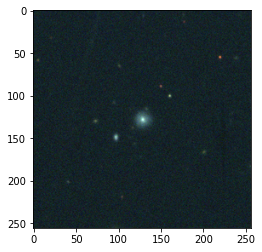

In [ ]:
plt.imshow(Input_images[2000])

In [ ]:
print('A lista de imagens tem {} imagens'.format(len(Input_images)))

print('A lista de labels tem {} labels,'.format(len(num_labels)))

print('dos quais {} são espirais, {} elípticos e {} incertos'.format(num_labels.count(0), num_labels.count(1), num_labels.count(2)))

A lista de imagens tem 4133 imagens
A lista de labels tem 4133 labels,
dos quais 2909 são espirais, 1224 elípticos e 0 incertos


É necessário limpar os valores incertos para fazer uma classificação binária. Além disso, para manetar a simplicidade, a classificação simples, o conjunto de imagens será balanceado. Primeiro excluindo os incertos:

In [ ]:
unc_idx = [] # Crio uma lista com índices de incertos

idx=0
for label in num_labels: # Loop para procurar índices 2 (incertos) na lista num_labels
    if label == 2:
        unc_idx.append(idx)
    idx += 1

unc_idx.sort(reverse=True) # reverto a ordem da lista para evitar problemas com mudanças de índice após pop

for index in unc_idx: # Loop que retira os objetos incertos da lista
    num_labels.pop(index)
    Input_images.pop(index)

Agora balanceando o conjunto de dados:

In [ ]:
while num_labels.count(0) != num_labels.count(1): 
    
    pop_idx = random.randint(0, len(num_labels)-1) # Gero índice aleatório de num_labels e caso seja 0 (espiral), removo das duas listas
    
    if num_labels[pop_idx] == 0:
        Input_images.pop(pop_idx)
        num_labels.pop(pop_idx)

In [ ]:
print('A lista de imagens tem {} imagens'.format(len(Input_images)))

print('A lista de labels tem {} labels,'.format(len(num_labels)))

print('dos quais {} são espirais, {} elípticos e {} incertos'.format(num_labels.count(0), num_labels.count(1), num_labels.count(2)))

A lista de imagens tem 2448 imagens
A lista de labels tem 2448 labels,
dos quais 1224 são espirais, 1224 elípticos e 0 incertos


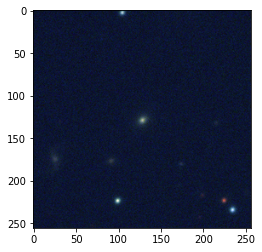

In [ ]:
plt.imshow(Input_images[4])

# Pré-processamento

In [ ]:
# transformando listas em arrays e verificando shapes
X = np.array(Input_images)
Y = np.array(num_labels)

del Input_images
del num_labels

# Separando em treinamento, validação e teste
x_train, x_val , y_train, y_val = train_test_split(X, Y, test_size=.3, stratify = Y) # 70% treinamento, 30% validação, que ainda será dividida para teste
x_val, x_test , y_val, y_test = train_test_split(x_val, y_val, test_size=1/3, stratify = y_val) # 2/3 (20% do total) para validação, 1/3 (10% do total) para teste

del X
del Y

# Aplicando One Hot Encoding aos labels
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

# Criando Gerador de Augmentation
train_generator = ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True )
train_generator.fit(x_train)

In [ ]:
#verificando dimensões
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)


((1713, 256, 256, 3), (1713, 2))
((490, 256, 256, 3), (490, 2))
((245, 256, 256, 3), (245, 2))


# Definição da Arquitetura

In [ ]:
ENB2 = EfficientNetB2(include_top=False, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=y_train.shape[1], classifier_activation='softmax')

In [ ]:
My_Model = Sequential()

My_Model.add(ENB2) 

My_Model.add(Flatten()) 

My_Model.add(Dropout(.5))

My_Model.add(Dense(256,activation=('relu')))

My_Model.add(Dense(2,activation=('softmax'))) 

My_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

#Checking the final My_Model summary
My_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 8, 8, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 90112)             0         
                                                                 
 dropout (Dropout)           (None, 90112)             0         
                                                                 
 dense (Dense)               (None, 256)               23068928  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 30,838,011
Trainable params: 30,770,436
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
# Definição do callback do checkpoint
filepath = 'my_best_model'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Fitting the model
My_Model_Fit = My_Model.fit(train_generator.flow(x_train, y_train, batch_size = 50), validation_data=(x_val, y_val), epochs=80, batch_size=50, verbose=0, callbacks=[TqdmCallback(verbose=0), checkpoint])

0epoch [00:00, ?epoch/s]


Epoch 1: val_binary_accuracy improved from -inf to 0.50000, saving model to my_best_model
INFO:tensorflow:Assets written to: my_best_model/assets

Epoch 2: val_binary_accuracy did not improve from 0.50000

Epoch 3: val_binary_accuracy did not improve from 0.50000

Epoch 4: val_binary_accuracy did not improve from 0.50000

Epoch 5: val_binary_accuracy did not improve from 0.50000

Epoch 6: val_binary_accuracy did not improve from 0.50000

Epoch 7: val_binary_accuracy did not improve from 0.50000

Epoch 8: val_binary_accuracy did not improve from 0.50000

Epoch 9: val_binary_accuracy did not improve from 0.50000

Epoch 10: val_binary_accuracy did not improve from 0.50000

Epoch 11: val_binary_accuracy did not improve from 0.50000

Epoch 12: val_binary_accuracy did not improve from 0.50000

Epoch 13: val_binary_accuracy did not improve from 0.50000

Epoch 14: val_binary_accuracy did not improve from 0.50000

Epoch 15: val_binary_accuracy did not improve from 0.50000

Epoch 16: val_binary

# Avaliação


O conjunto de labels de teste original é y_test. O OHE é aplicado sobre este conjunto mesmo, então para obter o conjunto ordinal original é preciso usar argmax.

In [ ]:
print(y_test[10:20])
y_true=np.argmax(y_test,axis=1)
print(y_true[10:20])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[0 0 1 0 1 0 0 0 0 1]


O Conjunto de predições é obtido aplicando o modelo a x_test

In [ ]:
predictions = My_Model.predict(x_test)

y_pred = [np.argmax(item) for item in predictions]
y_pred = np.array(y_pred)

print(predictions[10:20])
print(y_pred[10:20])

[[9.9997056e-01 2.9498160e-05]
 [9.9922109e-01 7.7888049e-04]
 [7.2456378e-01 2.7543625e-01]
 [9.9325693e-01 6.7431182e-03]
 [9.9102962e-01 8.9703938e-03]
 [9.7541624e-01 2.4583789e-02]
 [9.9994755e-01 5.2427960e-05]
 [1.7050037e-01 8.2949966e-01]
 [7.3852509e-01 2.6147491e-01]
 [1.2478672e-01 8.7521333e-01]]
[0 0 0 0 0 0 0 1 0 1]


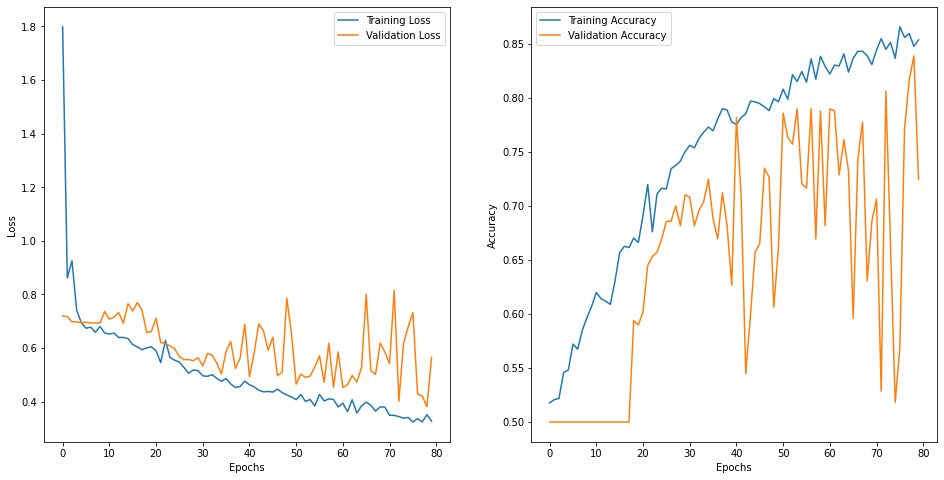

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (16, 8))

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')

ax[0].plot(My_Model_Fit.history['loss'], color='C0',label='Training Loss')
ax[0].plot(My_Model_Fit.history['val_loss'],color='C1',label='Validation Loss')
ax[0].legend()


ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')

ax[1].plot(My_Model_Fit.history['binary_accuracy'], color='C0',label='Training Accuracy')
ax[1].plot(My_Model_Fit.history['val_binary_accuracy'],color='C1',label='Validation Accuracy')
ax[1].legend()

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


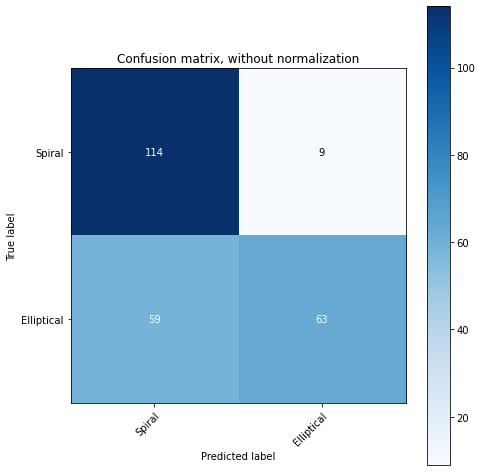

In [ ]:
predictions = My_Model.predict(x_test)

y_pred = [np.argmax(item) for item in predictions]
y_pred = np.array(y_pred)

y_true=np.argmax(y_test,axis=1)

from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['Spiral', 'Elliptical']

plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

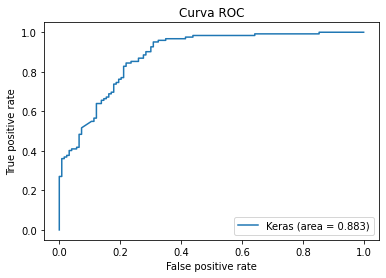

In [ ]:
from sklearn.metrics import roc_curve 
my_fpr, my_tpr, my_thresholds = roc_curve(y_true, predictions[:, 1])

from sklearn.metrics import auc
auc = auc(my_fpr, my_tpr)

fig, ax = plt.subplots()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC')
plt.plot(my_fpr, my_tpr, label='Keras (area = {:.3f})'.format(auc))
plt.legend(loc='best')

In [ ]:
#Classification accuracy
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true, y_pred)
print('Accuracy Score = ', acc_score)

Accuracy Score =  0.7224489795918367


# Avaliação com melhor modelo


In [ ]:
best_model = tf.keras.models.load_model('my_best_model')

O conjunto de labels de teste original é y_test. O OHE é aplicado sobre este conjunto mesmo, então para obter o conjunto ordinal original é preciso usar argmax.

O Conjunto de predições é obtido aplicando o modelo a x_test

Confusion matrix, without normalization


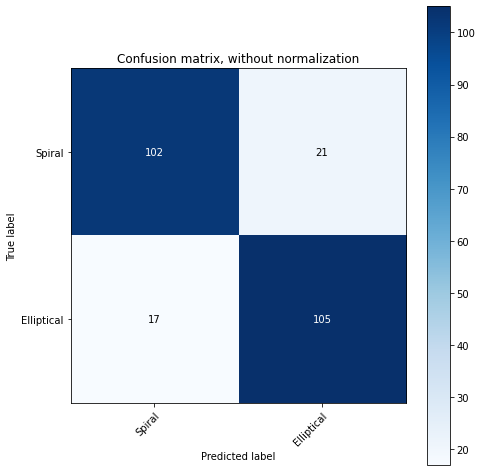

In [ ]:
best_predictions = best_model.predict(x_test)

best_y_pred = [np.argmax(item) for item in best_predictions]
best_y_pred = np.array(best_y_pred)

best_y_true=np.argmax(y_test,axis=1)

from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(best_y_true,best_y_pred)

class_names=['Spiral', 'Elliptical']

plot_confusion_matrix(best_y_true, best_y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

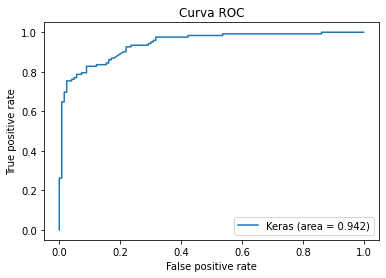

In [ ]:
from sklearn.metrics import roc_curve 
best_my_fpr, best_my_tpr, best_my_thresholds = roc_curve(best_y_true, best_predictions[:, 1])

from sklearn.metrics import auc
best_auc = auc(best_my_fpr, best_my_tpr)

fig, ax = plt.subplots()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC')
plt.plot(best_my_fpr, best_my_tpr, label='Keras (area = {:.3f})'.format(best_auc))
plt.legend(loc='best')

In [ ]:
#Classification accuracy
from sklearn.metrics import accuracy_score
best_acc_score = accuracy_score(best_y_true, best_y_pred)
print('Accuracy Score = ', best_acc_score)

Accuracy Score =  0.8448979591836735


# Salvando o modelo

In [ ]:
model_history = pd.DataFrame(data = My_Model_Fit.history)
model_history.index += 1 # Para que coluna index seja equivalente a época e comece em 1 em vez de 0

display(model_history)

,loss,binary_accuracy,val_loss,val_binary_accuracy
1,1.799245,0.517805,0.719502,0.500000
2,0.861485,0.520724,0.717056,0.500000
3,0.925624,0.521891,0.697772,0.500000
4,0.740715,0.545826,0.697767,0.500000
5,0.694547,0.548161,0.694549,0.500000
...,...,...,...,...
76,0.323671,0.865733,0.732257,0.569388
77,0.336247,0.855808,0.428451,0.771429
78,0.323843,0.859311,0.420687,0.816327
79,0.351209,0.847636,0.380762,0.838776


In [ ]:
# Salvando modelo
My_Model.save('/content/drive/MyDrive/.../modelos/EN-7/EN_7_80epochs')


#Salvando melhor modelo
best_model.save('/content/drive/MyDrive/.../modelos/EN-7/EN_7_best_model')

# Salvando histórico
model_history.to_csv('/content/drive/MyDrive/.../modelos/EN-7/EN_7_80epochs_history.csv', index=True) 